In [14]:
"""
Created on Fri Oct 22 10:20:45 2021
@author: ASHNER_NOVILLA
"""

'\nCreated on Fri Oct 22 10:20:45 2021\n@author: ASHNER_NOVILLA\n'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
raw_df = pd.read_csv(r'C:\Users\ASHNER_NOVILLA\Downloads\predictive_maintainece_dataset.csv')

In [17]:
raw_df_head = raw_df.head(5)
print(raw_df_head)

       date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/2015  S1F01085        0  215630672       55        0       52        6   
1  1/1/2015  S1F0166B        0   61370680        0        3        0        6   
2  1/1/2015  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/2015  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/2015  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  


In [18]:
#Check for the missing data
raw_df.isna().sum() # As we can see no missing data so no need for imputing missing data

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [19]:
# Split the Independent Variable and Target
df_independent = raw_df.iloc[:,3:]
df_dependent = raw_df.loc[:,raw_df.columns=='failure']

In [20]:
# Apply minmax for nomalization
# As we can see on the DataFrame that each atrributes have different Scale
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

In [21]:
# In this run, the dataset imbalace scaling is treated.
# from numpy import mean df_dependent dataframe that each attributes have different scale 
# Applying MinMaxScaler will normalize our dataset
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

df_independent_scaled = pd.DataFrame(minmaxscaler.fit_transform(df_independent), index = df_independent.index, columns = df_independent.columns)
print(df_independent_scaled.head(5))

    metric1   metric2  metric3   metric4   metric5   metric6  metric7  \
0  0.883224  0.000847  0.00000  0.031212  0.051546  0.591204      0.0   
1  0.251374  0.000000  0.00012  0.000000  0.051546  0.585017      0.0   
2  0.709821  0.000000  0.00000  0.000000  0.113402  0.344461      0.0   
3  0.326427  0.000000  0.00000  0.000000  0.051546  0.595191      0.0   
4  0.556935  0.000000  0.00000  0.000000  0.144330  0.454420      0.0   

   metric8   metric9  
0      0.0  0.000100  
1      0.0  0.000000  
2      0.0  0.000000  
3      0.0  0.000000  
4      0.0  0.000043  


<AxesSubplot:>

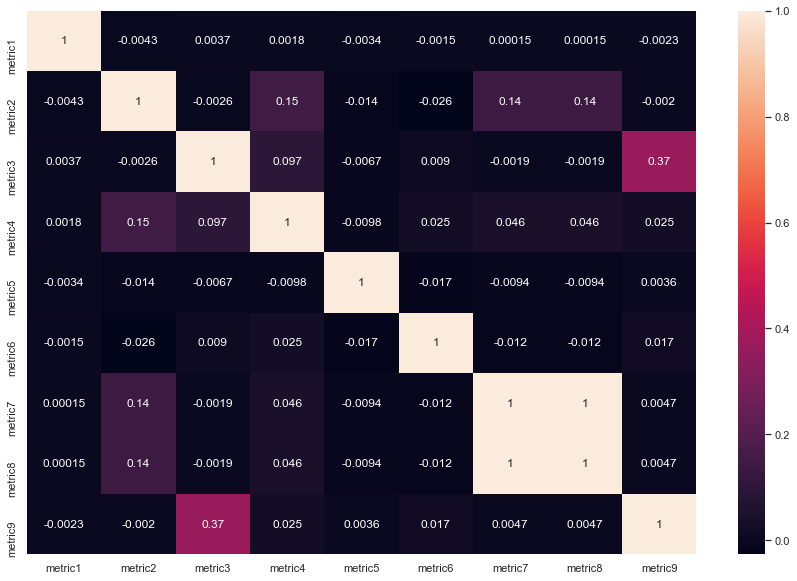

In [38]:
# We can see the correlation between each attributes
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_independent_scaled.corr(), annot = True)
# We can see that there is almost no correlation between attributes besides metric 7 and metric 8
# Since metric 7 and metric 8 has a correlation of 1 then we can remove either to lessen the attributes

In [29]:
# We will check if the data is a gaussian distribution using shapiro
import scipy.stats as stats
from scipy.stats import shapiro

In [30]:
df_stat_shapiro = []
column = []
status=[]

for col in df_independent_scaled.columns:
    # print(col)
    stat_shapiro = stats.shapiro(df_independent_scaled[col])
    # print(stat_shapiro)
    df_stat_shapiro.append(stat_shapiro[1])
    column.append(col)
    
    if stat_shapiro[1] > 0.05:
        x = 0
    else:
        x = 1    
    status.append(x)

del(stat_shapiro)
del(col)
del(x)

C:\Users\ASHNER_NOVILLA\anaconda3\envs\pycaret\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [31]:
df_stat_shapiro = pd.DataFrame(df_stat_shapiro, columns=["Shapiro_Test"])
column = pd.DataFrame(column)
df_stat_shapiro['columns'] = column
df_stat_shapiro["Status"] = status
df_stat_shapiro["Status"] = df_stat_shapiro.Status.replace(1,"Probably Not Gaussian")
df_stat_shapiro["Status"] = df_stat_shapiro.Status.replace(0,"Probably Gaussian")

del(column)
del(status)

In [32]:
df_stat_shapiro
# We can observed that are distribution is not gaussian
# Collected data might not be normally distributed if it represents simply a subset of the total output produced. 
# This can happen if data is collected and analyzed after sorting.
# Since we've the distribution is not Gaussian we will use algorithms that are robust for non normal distribution
# to predict the target.

,Shapiro_Test,columns,Status
0,0.0,metric1,Probably Not Gaussian
1,0.0,metric2,Probably Not Gaussian
2,0.0,metric3,Probably Not Gaussian
3,0.0,metric4,Probably Not Gaussian
4,0.0,metric5,Probably Not Gaussian
5,0.0,metric6,Probably Not Gaussian
6,0.0,metric7,Probably Not Gaussian
7,0.0,metric8,Probably Not Gaussian
8,0.0,metric9,Probably Not Gaussian


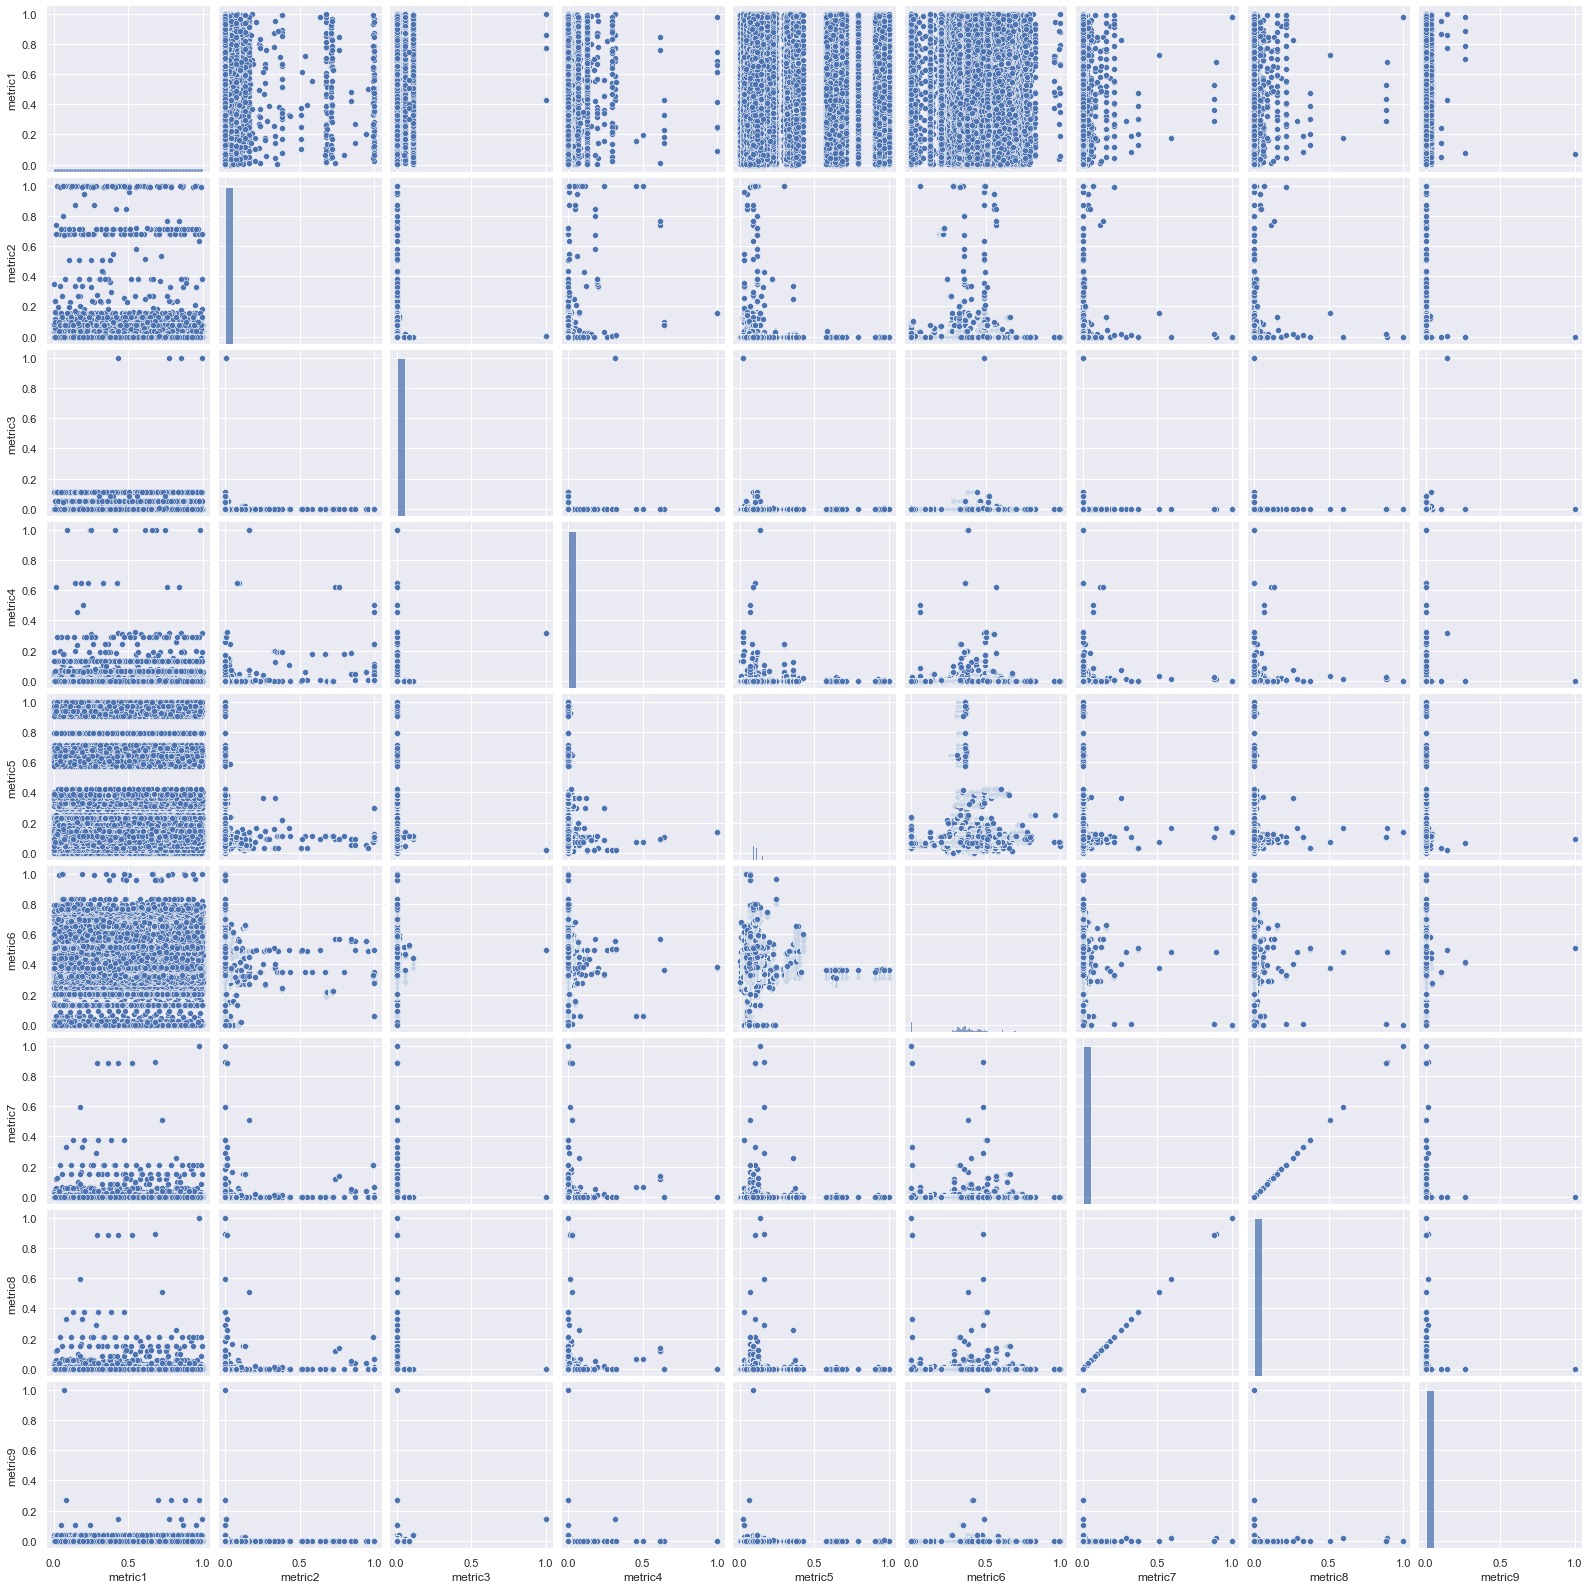

In [33]:
# Check the distribution using pair plot - comparison to other attributes.
sns.pairplot(df_independent_scaled)

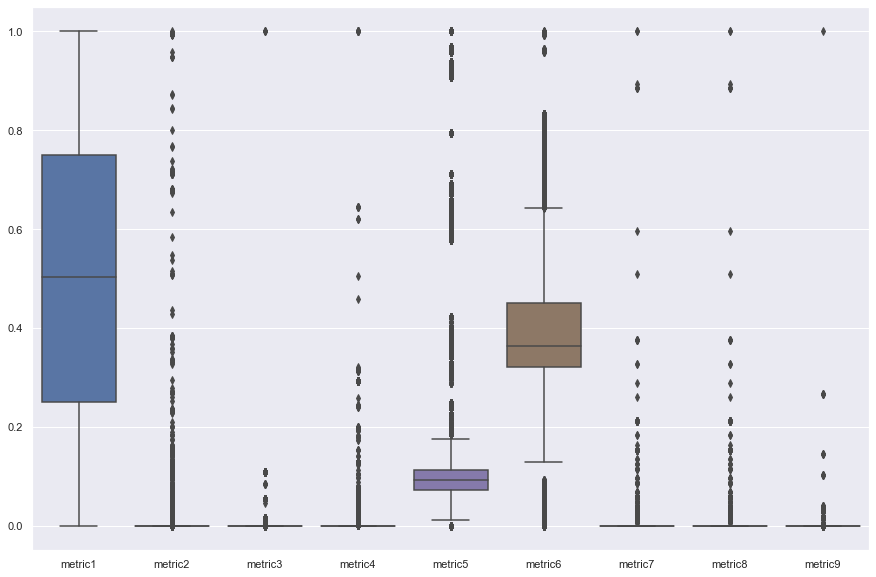

In [37]:
# Check the Outlier and Skewness of the Data
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data = df_independent_scaled).set_title =(df_independent_scaled.columns)
# As we can see that besides metric 1 - all other metrics have a huge outlier
# We have an option to impute the outlier using mean or median or mode imputation.
# We can also retain and accept the outliers 

In [22]:
#Check the shape of the data if the target("Failure") is balance or not.
df_dependent['failure'].value_counts() 
#We will see that great imabalance of dataset can be seen on the target.
# We will note this one and do a imbalance dataset treatment

0    124388
1       106
Name: failure, dtype: int64

In [77]:
# We remove metric 8 since it has a 100% correlinearty with metric 7. Thus we can say that metric 8 will 
# have same reading as metric 7. Removing it can lessen our training time and lessen the storage needed for data
df_independent_scaled = df_independent_scaled.loc[:,df_independent_scaled.columns != "metric8"]

In [78]:
# We will now treat the imbalance dataset

In [79]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [80]:
from collections import Counter
ros = RandomOverSampler(random_state = 0)
independent_resampled, dependent_resampled = ros.fit_resample(df_independent_scaled, df_dependent)
print(dependent_resampled.value_counts())
print(independent_resampled.shape)

failure
0          124388
1          124388
dtype: int64
(248776, 8)


In [81]:
#Apply train test split
from sklearn.model_selection import train_test_split

In [82]:
independent_train, independent_test, dependent_train, dependent_test = train_test_split(independent_resampled, dependent_resampled, test_size=0.25, random_state=42)

In [83]:
from sklearn.tree import DecisionTreeClassifier as DT
model = DT(criterion = 'entropy')
model.fit(independent_train, dependent_train)

DecisionTreeClassifier(criterion='entropy')

In [84]:
# Prediction on Train Data
preds_train = model.predict(independent_train)

In [85]:
# Metrics Checking
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy_train = accuracy_score(dependent_train, preds_train)
f1_score_train = f1_score(dependent_train, preds_train) 
precision_train = precision_score(dependent_train, preds_train)
recall_train = recall_score(dependent_train, preds_train)

print("Accuracy: ", accuracy_train)
print("f1_score: ",f1_score_train)
print("precision_score: ", precision_train)
print("recall_score: ",recall_train)

Accuracy:  0.9999946404261933
f1_score:  0.9999946319965216
precision_score:  0.9999892640506737
recall_score:  1.0


In [86]:
# Prediction on Test Data
preds_test = model.predict(independent_test)

In [87]:
model_test = DT(criterion = 'entropy')
model_test.fit(dependent_test, dependent_test)

DecisionTreeClassifier(criterion='entropy')

In [88]:
# Accuracy Checking
from sklearn.metrics import accuracy_score
accuracy_test = accuracy_score(dependent_test, preds_test)
f1_score_test = f1_score(dependent_test, preds_test) 
precision_test = precision_score(dependent_test, preds_test)
recall_test = recall_score(dependent_test, preds_test)

print("Accuracy: ", accuracy_test)
print("f1_score: ",f1_score_test)
print("precision_score: ", precision_test)
print("recall_score: ",recall_test)


Accuracy:  0.9996462681287585
f1_score:  0.9996480563109903
precision_score:  0.9992963602635451
recall_score:  1.0


In [89]:
# As we can see that after treatment of imbalance dataset using imblearn
# we got a, Accuracy of 0.999 for traing and 0.996 for test

# Applying Cross Validation to Further Enhance the Treatment for Imabalance

In [90]:
from numpy import mean
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [91]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [92]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=30, random_state=1)
scores = cross_val_score(pipeline, df_independent_scaled, df_dependent, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)
print(f'Scores for each fold are: {score}')

Scores for each fold are: 0.9963859010162328


In [ ]:
# Applying K-Fold Cross Vaildation to further verify if we have overfitting
# As we can see that each fold has a scores of 0.996

In [ ]:
# Recommendation that we need to further increase the samples we have to further verify the data